# Redes de Convolução Dilatadas

Nesta aula, vamos ver como usar redes de convolução para prever o tempo. Para isso, vamos usar um tipo de CNN que suporta uma operação diferente de convolução, a _convolução dilatada causal_.

In [2]:
from __future__ import print_function, division

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Introdução

CNNs foram projetadas principalmente para processamento espacial. Elas, contudo, são usadas também como sucesso para entradas de natureza sequencial, como frases, áudio etc. Nestes casos, elas tiram proveito do contexto observado na sequência, sem lidar realmente com o seu encadeamento sequêncial. Contudo, mais recentemente, arquiteturas têm sido propostas que são capazes de lidar mesmo com a natureza sequencial da informação. Um exemplo são as CNNs dilatadas (DC-CNNs), ou seja, CNNs com operações de convolução causais dilatadas.

A ideia geral das DC-CNNs é explorar o contexto da informação considerando sua direção causal. Em termos práticos, operações de convolução nestas CNNs são restritas a apenas uma direção. É mais fácil entender isso com um exemplo. Abaixo, temos o esquema de uma convolução causal 1-D de largura 2. Ou seja, cada neurônio observa duas entradas. Como a convolução é causal, note que o $t$-ésimo neurônio só pode observar entradas $t$ e $t-1$.

<img src="images/WaveNet_causalconv.png" alt="Convolução causal" style="width: 600px;"/>

Este tipo de operação permite a previsão de uma saída, pela observação de entradas anteriores a ela. Contudo, note no exemplo, que para observar 5 entradas, a rede precisa de 3 camadas ocultas. Para observar uma série com 16 entradas, seriam necessárias 14 camadas, tornando a rede rapidamente  inviável para sequencias maiores.

Uma forma de resolver este problema é atraves de _convoluções dilatadas_, ou seja convoluções aplicadas à entrada com intervalos de tamanhos pré-definidos. Por exemplo, com apenas 3 camadas é possível observar 16 entradas se cada camada possuir o dobro de intervalos da camada anterior, como visto abaixo:

<img src="images/WaveNet_dilatedconv.png" alt="Convolução causal" style="width: 600px;"/>

A quantidade de intervalos entre duas observações é chamada _fator de dilatação_. Uma convolução normal pode ser vista como uma convolução em que o fator de dilatação $k = 1$. Com $k=2$, a convolução saltaria uma a cada duas entradas. Com $k=4$, seriam saltadas 3 entradas. 

Estas operações de convolução possibilitam que se aumente o "campo receptivo" de um neurônio exponencialmente com um aumento apenas linear do número de parâmetros. Assim, é possível se explorar a sequência de elementos tanto de forma detalhada quanto geral, sem grande custo processamento.

Assim, usando convoluções causais dilatadas, é possível usar CNNs para preverem o próximo elemento de uma sequência, tornando possível o seu uso como previsores temporais, como ilustrado abaixo:

<img src="images/dilation_animation.gif" alt="Animação de dilations" style="width: 500px;"/>

Neste notebook, vamos implementar esta estratégia de previsão.

### Uma arquitetura CNN dilatada

Em particular, vamos implementar a rede _seriesnet_, uma DN-CNN com a arquitetura ilustrada a seguir:

<img src="images/dilatedCNN.png" alt="CNN dilatada" style="width: 500px;"/>

Nesta arquitetura, em particular, 7 camadas são empilhadas. Cada camada corresponde a um bloco com diferente fator de dilatação (bloco DC-CNN). A saída de todos os blocos é somada e transformada por uma operação _relu_. O resultado é então combinado em uma convolução de largura 1 que gera a previsão $\hat{y}$. 

Cada bloco DC-CNN corresponde a um conjunto de filtros de convolução causal dilatada, com saída tanto para o próximo bloco quanto para o somador final. Ambas as saídas ainda são transformadas por uma operação relu e combinadas via camadas de convolução 1x1. A saída para o próximo bloco é residual. A seguir, temos a implementação desta arquitetura em Keras.

In [4]:
#Se vocês estiverem tendo crashes estranhos quando rodarem as convolucoes, 
#pode ser um problema do CUDA nao estar gerenciando bem a memoria. Descomentem essas linhas nesse caso
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

from keras.layers import Conv1D, Input, Add, Activation, Dropout
from keras.models import Sequential, Model
from keras.regularizers import l2
from keras.initializers import TruncatedNormal
from keras.layers.advanced_activations import LeakyReLU, ELU
from keras import optimizers



In [5]:
def DC_CNN_Block(nb_filter, filter_length, dilation, l2_layer_reg):
    def block(block_input):        
        residual =    block_input
        
        layer_out =   Conv1D(filters=nb_filter, kernel_size=filter_length, 
                      dilation_rate=dilation, 
                      activation='linear', padding='causal', use_bias=False,
                      kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, 
                      seed=42), kernel_regularizer=l2(l2_layer_reg))(block_input)                    
        selu_out =    Activation('selu')(layer_out)
        
        skip_out =    Conv1D(1,1, activation='linear', use_bias=False, 
                      kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, 
                      seed=42), kernel_regularizer=l2(l2_layer_reg))(selu_out)
        
        c1x1_out =    Conv1D(1,1, activation='linear', use_bias=False, 
                      kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, 
                      seed=42), kernel_regularizer=l2(l2_layer_reg))(selu_out)
                      
        block_out =   Add()([residual, c1x1_out])
        
        return block_out, skip_out
    return block

In [6]:
def DC_CNN_Model(length):
    visible = Input(shape=(length, 1))
    
    l1a, l1b = DC_CNN_Block(32,2,1,0.001)(visible)    
    l2a, l2b = DC_CNN_Block(32,2,2,0.001)(l1a) 
    l3a, l3b = DC_CNN_Block(32,2,4,0.001)(l2a)
    l4a, l4b = DC_CNN_Block(32,2,8,0.001)(l3a)
    l5a, l5b = DC_CNN_Block(32,2,16,0.001)(l4a)
    l6a, l6b = DC_CNN_Block(32,2,32,0.001)(l5a)
    l7a, l7b = DC_CNN_Block(32,2,64,0.001)(l6a)

    l8 =   Add()([l1b, l2b, l3b, l4b, l5b, l6b, l7b])  
    
    l9 =   Activation('relu')(l8)
           
    yhat =  Conv1D(1,1, activation='linear', use_bias=False, 
            kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=42),
            kernel_regularizer=l2(0.001))(l9)

    model = Model(inputs=visible, outputs=yhat)
    
    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0)

    model.compile(loss='mae', optimizer=adam, metrics=['mse'])
    return model

### Usando CNNs dilatadas para previsão de séries de tempo

Para testar nosso modelo, vamos usar uma série com informaçoes sobre o número de passageiros em vôos nos EUA entre 1949 e 1961.

In [7]:
import pandas as pd

In [8]:
airline = pd.read_csv('data/airline.csv')

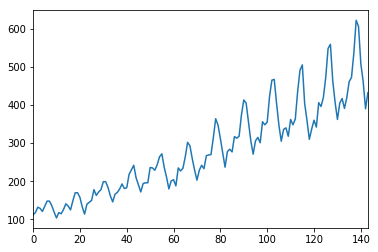

In [9]:
airline['passengers'].plot()

Esta série apresenta clara sazonalidade e uma tendência de crescimento. A seguir, Vamos agora fazer uma previsão para um horizonte de 40 dias:

In [10]:
forecast_horizon = 40

In [11]:
Xpast = airline['passengers'].iloc[:-forecast_horizon]
Xreal = airline['passengers'].iloc[-forecast_horizon:] 

In [12]:
Xpast = np.atleast_2d(np.asarray(Xpast)).T

In [13]:
length = len(Xpast)-1

In [14]:
model = DC_CNN_Model(length)

In [15]:
X = Xpast[:-1].reshape(1,length,1)
y = Xpast[1:].reshape(1,length,1)    

In [16]:
print(X[0,:5,:].T)
print(y[0,:5,:].T)

[[112 118 132 129 121]]
[[118 132 129 121 135]]


In [17]:
model.fit(X, y, epochs=500)

Epoch 1/500
1/1 [==============================] - 2s 2s/step - loss: 228.4865 - mean_squared_error: 59145.7773
Epoch 2/500
1/1 [==============================] - 0s 17ms/step - loss: 228.3858 - mean_squared_error: 59093.4375
Epoch 3/500
1/1 [==============================] - 0s 13ms/step - loss: 228.2773 - mean_squared_error: 59036.9805
Epoch 4/500
1/1 [==============================] - 0s 14ms/step - loss: 228.1710 - mean_squared_error: 58981.7461
Epoch 5/500
1/1 [==============================] - 0s 13ms/step - loss: 228.0708 - mean_squared_error: 58929.6328
Epoch 6/500
1/1 [==============================] - 0s 13ms/step - loss: 227.9783 - mean_squared_error: 58881.5000
Epoch 7/500
1/1 [==============================] - 0s 13ms/step - loss: 227.8943 - mean_squared_error: 58837.7656
Epoch 8/500
1/1 [==============================] - 0s 14ms/step - loss: 227.8192 - mean_squared_error: 58798.6562
Epoch 9/500
1/1 [==============================] - 0s 14ms/step - loss: 227.7531 - mean_sq

Epoch 73/500
1/1 [==============================] - 0s 15ms/step - loss: 224.9190 - mean_squared_error: 57294.5156
Epoch 74/500
1/1 [==============================] - 0s 15ms/step - loss: 224.4628 - mean_squared_error: 57060.3789
Epoch 75/500
1/1 [==============================] - 0s 12ms/step - loss: 223.9421 - mean_squared_error: 56793.8008
Epoch 76/500
1/1 [==============================] - 0s 14ms/step - loss: 223.3505 - mean_squared_error: 56491.7070
Epoch 77/500
1/1 [==============================] - 0s 12ms/step - loss: 222.6808 - mean_squared_error: 56150.8477
Epoch 78/500
1/1 [==============================] - 0s 15ms/step - loss: 221.9259 - mean_squared_error: 55767.8555
Epoch 79/500
1/1 [==============================] - 0s 15ms/step - loss: 221.0775 - mean_squared_error: 55338.8242
Epoch 80/500
1/1 [==============================] - 0s 15ms/step - loss: 220.1259 - mean_squared_error: 54859.5586
Epoch 81/500
1/1 [==============================] - 0s 12ms/step - loss: 219.060

Epoch 145/500
1/1 [==============================] - 0s 15ms/step - loss: 30.2466 - mean_squared_error: 1344.3521
Epoch 146/500
1/1 [==============================] - 0s 14ms/step - loss: 30.2728 - mean_squared_error: 1349.4454
Epoch 147/500
1/1 [==============================] - 0s 13ms/step - loss: 30.3722 - mean_squared_error: 1366.4506
Epoch 148/500
1/1 [==============================] - 0s 14ms/step - loss: 30.4900 - mean_squared_error: 1384.9657
Epoch 149/500
1/1 [==============================] - 0s 14ms/step - loss: 30.5384 - mean_squared_error: 1395.8489
Epoch 150/500
1/1 [==============================] - 0s 14ms/step - loss: 30.4843 - mean_squared_error: 1395.7000
Epoch 151/500
1/1 [==============================] - 0s 13ms/step - loss: 30.3370 - mean_squared_error: 1384.0154
Epoch 152/500
1/1 [==============================] - 0s 19ms/step - loss: 30.1004 - mean_squared_error: 1362.3630
Epoch 153/500
1/1 [==============================] - 0s 14ms/step - loss: 29.8010 - mean

Epoch 217/500
1/1 [==============================] - 0s 18ms/step - loss: 23.3770 - mean_squared_error: 952.8572
Epoch 218/500
1/1 [==============================] - 0s 14ms/step - loss: 23.3305 - mean_squared_error: 952.0756
Epoch 219/500
1/1 [==============================] - 0s 15ms/step - loss: 23.2774 - mean_squared_error: 948.8235
Epoch 220/500
1/1 [==============================] - 0s 16ms/step - loss: 23.2177 - mean_squared_error: 943.3491
Epoch 221/500
1/1 [==============================] - 0s 15ms/step - loss: 23.1612 - mean_squared_error: 937.4039
Epoch 222/500
1/1 [==============================] - 0s 15ms/step - loss: 23.1168 - mean_squared_error: 932.1450
Epoch 223/500
1/1 [==============================] - 0s 13ms/step - loss: 23.0731 - mean_squared_error: 929.5579
Epoch 224/500
1/1 [==============================] - 0s 13ms/step - loss: 23.0215 - mean_squared_error: 929.2179
Epoch 225/500
1/1 [==============================] - 0s 13ms/step - loss: 22.9797 - mean_squared

Epoch 290/500
1/1 [==============================] - 0s 16ms/step - loss: 20.7950 - mean_squared_error: 779.2795
Epoch 291/500
1/1 [==============================] - 0s 17ms/step - loss: 20.7641 - mean_squared_error: 776.8096
Epoch 292/500
1/1 [==============================] - 0s 11ms/step - loss: 20.7258 - mean_squared_error: 769.6382
Epoch 293/500
1/1 [==============================] - 0s 13ms/step - loss: 20.6958 - mean_squared_error: 767.2703
Epoch 294/500
1/1 [==============================] - 0s 15ms/step - loss: 20.6772 - mean_squared_error: 769.1994
Epoch 295/500
1/1 [==============================] - 0s 14ms/step - loss: 20.6335 - mean_squared_error: 762.9396
Epoch 296/500
1/1 [==============================] - 0s 14ms/step - loss: 20.6066 - mean_squared_error: 761.3568
Epoch 297/500
1/1 [==============================] - 0s 14ms/step - loss: 20.5886 - mean_squared_error: 755.1033
Epoch 298/500
1/1 [==============================] - 0s 14ms/step - loss: 20.5650 - mean_squared

Epoch 363/500
1/1 [==============================] - 0s 14ms/step - loss: 19.3820 - mean_squared_error: 622.7943
Epoch 364/500
1/1 [==============================] - 0s 14ms/step - loss: 19.3517 - mean_squared_error: 623.0983
Epoch 365/500
1/1 [==============================] - 0s 14ms/step - loss: 19.3591 - mean_squared_error: 625.6342
Epoch 366/500
1/1 [==============================] - 0s 14ms/step - loss: 19.3166 - mean_squared_error: 622.1271
Epoch 367/500
1/1 [==============================] - 0s 13ms/step - loss: 19.3047 - mean_squared_error: 617.0654
Epoch 368/500
1/1 [==============================] - 0s 14ms/step - loss: 19.3011 - mean_squared_error: 614.6942
Epoch 369/500
1/1 [==============================] - 0s 14ms/step - loss: 19.2635 - mean_squared_error: 614.3620
Epoch 370/500
1/1 [==============================] - 0s 16ms/step - loss: 19.2276 - mean_squared_error: 615.5488
Epoch 371/500
1/1 [==============================] - 0s 15ms/step - loss: 19.2464 - mean_squared

Epoch 436/500
1/1 [==============================] - 0s 18ms/step - loss: 18.1465 - mean_squared_error: 546.1235
Epoch 437/500
1/1 [==============================] - 0s 13ms/step - loss: 18.1400 - mean_squared_error: 545.2197
Epoch 438/500
1/1 [==============================] - 0s 15ms/step - loss: 18.1148 - mean_squared_error: 550.4960
Epoch 439/500
1/1 [==============================] - 0s 14ms/step - loss: 18.1373 - mean_squared_error: 553.1855
Epoch 440/500
1/1 [==============================] - 0s 14ms/step - loss: 18.0897 - mean_squared_error: 546.0526
Epoch 441/500
1/1 [==============================] - 0s 18ms/step - loss: 18.1167 - mean_squared_error: 541.5514
Epoch 442/500
1/1 [==============================] - 0s 16ms/step - loss: 18.0725 - mean_squared_error: 543.6612
Epoch 443/500
1/1 [==============================] - 0s 15ms/step - loss: 18.0650 - mean_squared_error: 546.7310
Epoch 444/500
1/1 [==============================] - 0s 14ms/step - loss: 18.0718 - mean_squared

In [20]:
#model.summary()
X_test_initial = Xpast[1:].reshape(1,length,1)
X_trfit = model.predict(X_test_initial)

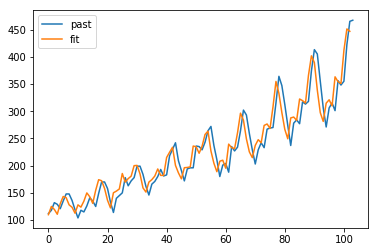

In [21]:
plt.plot(Xpast, label = 'past')
plt.plot(X_trfit.flatten(), label = 'fit')
plt.legend(loc = 'upper left')

In [22]:
preds = np.zeros(forecast_horizon)
preds[0] = model.predict(X_test_initial)[0,-1,0]

for i in range(1, forecast_horizon):
    X_test_i = np.append(X_test_initial[0,i:,:], preds[:i])
    preds[i] = model.predict(X_test_i.reshape(1, length, 1))[0,-1,0]

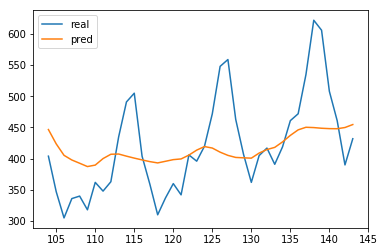

In [23]:
plt.plot(Xreal, label = 'real')
plt.plot(pd.DataFrame(preds, index=Xreal.index), label = 'pred')
plt.legend()

Juntando tudo:

In [29]:
def evaluate_timeseries(timeseries, predict_size, n_epochs = 3000):
    # timeseries input is 1-D numpy array
    # forecast_size is the forecast horizon
    
    # remove missing data
    timeseries = timeseries[~pd.isnull(timeseries)]

    length = len(timeseries)-1

    timeseries = np.atleast_2d(np.asarray(timeseries))
    if timeseries.shape[0] == 1:
        timeseries = timeseries.T 

    model = DC_CNN_Model(length)
    print('\n\nModel input size',model.input_shape, 'output size' , model.output_shape)
    
    model.summary()

    # prime model
    X = timeseries[:-1].reshape(1,length,1)
    y = timeseries[1:].reshape(1,length,1)    
    model.fit(X, y, epochs=n_epochs)
    
    # get fit for training data
    X_test_initial = timeseries[1:].reshape(1,length,1)
    X_trfit = model.predict(X_test_initial) 
        
    # forecast is created by predicting next future 
    # value based on previous predictions
    preds = np.zeros(forecast_horizon)
    preds[0] = model.predict(X_test_initial)[0,-1,0]
    for i in range(1, forecast_horizon):
        X_test_i = np.append(X_test_initial[0,i:,:], preds[:i])
        preds[i] = model.predict(X_test_i.reshape(1, length, 1))[0,-1,0]
        
    return preds, X_trfit.flatten()

In [30]:
Xpred, Xfit = evaluate_timeseries(Xpast, forecast_horizon, n_epochs = 4000)



Model input size (None, 103, 1) output size (None, 103, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 103, 1)       0                                            
__________________________________________________________________________________________________
conv1d_67 (Conv1D)              (None, 103, 32)      64          input_4[0][0]                    
__________________________________________________________________________________________________
activation_25 (Activation)      (None, 103, 32)      0           conv1d_67[0][0]                  
__________________________________________________________________________________________________
conv1d_69 (Conv1D)              (None, 103, 1)       32          activation_25[0][0]              
________________________________________________

Epoch 1/4000
1/1 [==============================] - 2s 2s/step - loss: 228.4865 - mean_squared_error: 59145.7773
Epoch 2/4000
1/1 [==============================] - 0s 16ms/step - loss: 228.3858 - mean_squared_error: 59093.4375
Epoch 3/4000
1/1 [==============================] - 0s 18ms/step - loss: 228.2773 - mean_squared_error: 59036.9805
Epoch 4/4000
1/1 [==============================] - 0s 21ms/step - loss: 228.1710 - mean_squared_error: 58981.7461
Epoch 5/4000
1/1 [==============================] - 0s 14ms/step - loss: 228.0708 - mean_squared_error: 58929.6328
Epoch 6/4000
1/1 [==============================] - 0s 16ms/step - loss: 227.9783 - mean_squared_error: 58881.5000
Epoch 7/4000
1/1 [==============================] - 0s 14ms/step - loss: 227.8943 - mean_squared_error: 58837.7656
Epoch 8/4000
1/1 [==============================] - 0s 15ms/step - loss: 227.8192 - mean_squared_error: 58798.6562
Epoch 9/4000
1/1 [==============================] - 0s 12ms/step - loss: 227.7531 

Epoch 72/4000
1/1 [==============================] - 0s 16ms/step - loss: 225.3168 - mean_squared_error: 57498.9922
Epoch 73/4000
1/1 [==============================] - 0s 17ms/step - loss: 224.9190 - mean_squared_error: 57294.5156
Epoch 74/4000
1/1 [==============================] - 0s 15ms/step - loss: 224.4628 - mean_squared_error: 57060.3789
Epoch 75/4000
1/1 [==============================] - 0s 15ms/step - loss: 223.9421 - mean_squared_error: 56793.8008
Epoch 76/4000
1/1 [==============================] - 0s 13ms/step - loss: 223.3505 - mean_squared_error: 56491.7070
Epoch 77/4000
1/1 [==============================] - 0s 13ms/step - loss: 222.6808 - mean_squared_error: 56150.8477
Epoch 78/4000
1/1 [==============================] - 0s 14ms/step - loss: 221.9259 - mean_squared_error: 55767.8555
Epoch 79/4000
1/1 [==============================] - 0s 18ms/step - loss: 221.0775 - mean_squared_error: 55338.8242
Epoch 80/4000
1/1 [==============================] - 0s 13ms/step - loss

Epoch 143/4000
1/1 [==============================] - 0s 16ms/step - loss: 31.1183 - mean_squared_error: 1399.8120
Epoch 144/4000
1/1 [==============================] - 0s 15ms/step - loss: 30.5620 - mean_squared_error: 1360.6967
Epoch 145/4000
1/1 [==============================] - 0s 20ms/step - loss: 30.2466 - mean_squared_error: 1344.3519
Epoch 146/4000
1/1 [==============================] - 0s 16ms/step - loss: 30.2728 - mean_squared_error: 1349.4454
Epoch 147/4000
1/1 [==============================] - 0s 13ms/step - loss: 30.3722 - mean_squared_error: 1366.4504
Epoch 148/4000
1/1 [==============================] - 0s 15ms/step - loss: 30.4900 - mean_squared_error: 1384.9657
Epoch 149/4000
1/1 [==============================] - 0s 15ms/step - loss: 30.5384 - mean_squared_error: 1395.8489
Epoch 150/4000
1/1 [==============================] - 0s 12ms/step - loss: 30.4843 - mean_squared_error: 1395.6998
Epoch 151/4000
1/1 [==============================] - 0s 12ms/step - loss: 30.33

Epoch 215/4000
1/1 [==============================] - 0s 12ms/step - loss: 23.4889 - mean_squared_error: 951.3965
Epoch 216/4000
1/1 [==============================] - 0s 15ms/step - loss: 23.4266 - mean_squared_error: 950.8071
Epoch 217/4000
1/1 [==============================] - 0s 16ms/step - loss: 23.3761 - mean_squared_error: 951.8941
Epoch 218/4000
1/1 [==============================] - 0s 17ms/step - loss: 23.3313 - mean_squared_error: 951.8985
Epoch 219/4000
1/1 [==============================] - 0s 14ms/step - loss: 23.2807 - mean_squared_error: 949.4135
Epoch 220/4000
1/1 [==============================] - 0s 16ms/step - loss: 23.2213 - mean_squared_error: 944.5809
Epoch 221/4000
1/1 [==============================] - 0s 14ms/step - loss: 23.1616 - mean_squared_error: 937.8751
Epoch 222/4000
1/1 [==============================] - 0s 17ms/step - loss: 23.1207 - mean_squared_error: 931.0665
Epoch 223/4000
1/1 [==============================] - 0s 16ms/step - loss: 23.0833 - mea

Epoch 287/4000
1/1 [==============================] - 0s 19ms/step - loss: 20.8896 - mean_squared_error: 782.8857
Epoch 288/4000
1/1 [==============================] - 0s 13ms/step - loss: 20.8579 - mean_squared_error: 780.6843
Epoch 289/4000
1/1 [==============================] - 0s 14ms/step - loss: 20.8264 - mean_squared_error: 778.5605
Epoch 290/4000
1/1 [==============================] - 0s 15ms/step - loss: 20.7977 - mean_squared_error: 773.4528
Epoch 291/4000
1/1 [==============================] - 0s 16ms/step - loss: 20.7599 - mean_squared_error: 773.0850
Epoch 292/4000
1/1 [==============================] - 0s 19ms/step - loss: 20.7365 - mean_squared_error: 774.3766
Epoch 293/4000
1/1 [==============================] - 0s 19ms/step - loss: 20.6972 - mean_squared_error: 770.1060
Epoch 294/4000
1/1 [==============================] - 0s 19ms/step - loss: 20.6750 - mean_squared_error: 762.8076
Epoch 295/4000
1/1 [==============================] - 0s 16ms/step - loss: 20.6291 - mea

Epoch 359/4000
1/1 [==============================] - 0s 15ms/step - loss: 19.3934 - mean_squared_error: 625.3079
Epoch 360/4000
1/1 [==============================] - 0s 13ms/step - loss: 19.3558 - mean_squared_error: 626.6990
Epoch 361/4000
1/1 [==============================] - 0s 17ms/step - loss: 19.3534 - mean_squared_error: 629.2136
Epoch 362/4000
1/1 [==============================] - 0s 20ms/step - loss: 19.3231 - mean_squared_error: 627.0314
Epoch 363/4000
1/1 [==============================] - 0s 14ms/step - loss: 19.2946 - mean_squared_error: 622.4525
Epoch 364/4000
1/1 [==============================] - 0s 22ms/step - loss: 19.2845 - mean_squared_error: 620.0392
Epoch 365/4000
1/1 [==============================] - 0s 14ms/step - loss: 19.2636 - mean_squared_error: 619.3071
Epoch 366/4000
1/1 [==============================] - 0s 15ms/step - loss: 19.2359 - mean_squared_error: 620.3415
Epoch 367/4000
1/1 [==============================] - 0s 13ms/step - loss: 19.2253 - mea

Epoch 431/4000
1/1 [==============================] - 0s 13ms/step - loss: 18.0860 - mean_squared_error: 549.7773
Epoch 432/4000
1/1 [==============================] - 0s 12ms/step - loss: 18.0750 - mean_squared_error: 548.8521
Epoch 433/4000
1/1 [==============================] - 0s 15ms/step - loss: 18.0618 - mean_squared_error: 547.0369
Epoch 434/4000
1/1 [==============================] - 0s 14ms/step - loss: 18.0680 - mean_squared_error: 544.6190
Epoch 435/4000
1/1 [==============================] - 0s 14ms/step - loss: 18.0484 - mean_squared_error: 547.5420
Epoch 436/4000
1/1 [==============================] - 0s 16ms/step - loss: 18.0329 - mean_squared_error: 545.9929
Epoch 437/4000
1/1 [==============================] - 0s 12ms/step - loss: 18.0256 - mean_squared_error: 542.4583
Epoch 438/4000
1/1 [==============================] - 0s 18ms/step - loss: 18.0117 - mean_squared_error: 544.5422
Epoch 439/4000
1/1 [==============================] - 0s 13ms/step - loss: 18.0045 - mea

Epoch 503/4000
1/1 [==============================] - 0s 16ms/step - loss: 17.3786 - mean_squared_error: 515.7578
Epoch 504/4000
1/1 [==============================] - 0s 14ms/step - loss: 17.3565 - mean_squared_error: 511.6625
Epoch 505/4000
1/1 [==============================] - 0s 13ms/step - loss: 17.3611 - mean_squared_error: 506.8092
Epoch 506/4000
1/1 [==============================] - 0s 12ms/step - loss: 17.3397 - mean_squared_error: 510.9784
Epoch 507/4000
1/1 [==============================] - 0s 13ms/step - loss: 17.3417 - mean_squared_error: 513.5405
Epoch 508/4000
1/1 [==============================] - 0s 16ms/step - loss: 17.3221 - mean_squared_error: 509.8894
Epoch 509/4000
1/1 [==============================] - 0s 14ms/step - loss: 17.3312 - mean_squared_error: 505.3877
Epoch 510/4000
1/1 [==============================] - 0s 15ms/step - loss: 17.3058 - mean_squared_error: 509.9347
Epoch 511/4000
1/1 [==============================] - 0s 16ms/step - loss: 17.3090 - mea

Epoch 575/4000
1/1 [==============================] - 0s 15ms/step - loss: 16.7900 - mean_squared_error: 516.7656
Epoch 576/4000
1/1 [==============================] - 0s 17ms/step - loss: 16.7849 - mean_squared_error: 508.1860
Epoch 577/4000
1/1 [==============================] - 0s 13ms/step - loss: 16.7914 - mean_squared_error: 502.8878
Epoch 578/4000
1/1 [==============================] - 0s 17ms/step - loss: 16.7810 - mean_squared_error: 505.5457
Epoch 579/4000
1/1 [==============================] - 0s 18ms/step - loss: 16.7748 - mean_squared_error: 509.8811
Epoch 580/4000
1/1 [==============================] - 0s 13ms/step - loss: 16.7742 - mean_squared_error: 516.0169
Epoch 581/4000
1/1 [==============================] - 0s 15ms/step - loss: 16.7704 - mean_squared_error: 515.5109
Epoch 582/4000
1/1 [==============================] - 0s 16ms/step - loss: 16.7656 - mean_squared_error: 513.1501
Epoch 583/4000
1/1 [==============================] - 0s 17ms/step - loss: 16.7614 - mea

Epoch 647/4000
1/1 [==============================] - 0s 15ms/step - loss: 16.5979 - mean_squared_error: 517.6041
Epoch 648/4000
1/1 [==============================] - 0s 13ms/step - loss: 16.5957 - mean_squared_error: 518.8022
Epoch 649/4000
1/1 [==============================] - 0s 15ms/step - loss: 16.5936 - mean_squared_error: 517.4732
Epoch 650/4000
1/1 [==============================] - 0s 16ms/step - loss: 16.6072 - mean_squared_error: 527.3707
Epoch 651/4000
1/1 [==============================] - 0s 17ms/step - loss: 16.6016 - mean_squared_error: 526.4157
Epoch 652/4000
1/1 [==============================] - 0s 15ms/step - loss: 16.5923 - mean_squared_error: 515.8472
Epoch 653/4000
1/1 [==============================] - 0s 13ms/step - loss: 16.5861 - mean_squared_error: 517.2802
Epoch 654/4000
1/1 [==============================] - 0s 17ms/step - loss: 16.5882 - mean_squared_error: 525.0546
Epoch 655/4000
1/1 [==============================] - 0s 14ms/step - loss: 16.5796 - mea

Epoch 719/4000
1/1 [==============================] - 0s 16ms/step - loss: 16.4248 - mean_squared_error: 518.4038
Epoch 720/4000
1/1 [==============================] - 0s 15ms/step - loss: 16.4004 - mean_squared_error: 535.3893
Epoch 721/4000
1/1 [==============================] - 0s 15ms/step - loss: 16.4097 - mean_squared_error: 539.4783
Epoch 722/4000
1/1 [==============================] - 0s 13ms/step - loss: 16.4040 - mean_squared_error: 521.6654
Epoch 723/4000
1/1 [==============================] - 0s 17ms/step - loss: 16.4155 - mean_squared_error: 518.1301
Epoch 724/4000
1/1 [==============================] - 0s 16ms/step - loss: 16.3860 - mean_squared_error: 534.6678
Epoch 725/4000
1/1 [==============================] - 0s 19ms/step - loss: 16.4416 - mean_squared_error: 546.8613
Epoch 726/4000
1/1 [==============================] - 0s 14ms/step - loss: 16.4078 - mean_squared_error: 518.5618
Epoch 727/4000
1/1 [==============================] - 0s 15ms/step - loss: 16.4254 - mea

Epoch 791/4000
1/1 [==============================] - 0s 13ms/step - loss: 16.2799 - mean_squared_error: 514.0201
Epoch 792/4000
1/1 [==============================] - 0s 18ms/step - loss: 16.2665 - mean_squared_error: 516.2878
Epoch 793/4000
1/1 [==============================] - 0s 17ms/step - loss: 16.2621 - mean_squared_error: 537.1535
Epoch 794/4000
1/1 [==============================] - 0s 20ms/step - loss: 16.2215 - mean_squared_error: 525.7361
Epoch 795/4000
1/1 [==============================] - 0s 16ms/step - loss: 16.2277 - mean_squared_error: 522.9104
Epoch 796/4000
1/1 [==============================] - 0s 15ms/step - loss: 16.2775 - mean_squared_error: 539.4396
Epoch 797/4000
1/1 [==============================] - 0s 16ms/step - loss: 16.2391 - mean_squared_error: 518.6422
Epoch 798/4000
1/1 [==============================] - 0s 15ms/step - loss: 16.2346 - mean_squared_error: 518.7708
Epoch 799/4000
1/1 [==============================] - 0s 20ms/step - loss: 16.2641 - mea

Epoch 863/4000
1/1 [==============================] - 0s 14ms/step - loss: 16.0837 - mean_squared_error: 521.0229
Epoch 864/4000
1/1 [==============================] - 0s 14ms/step - loss: 16.0996 - mean_squared_error: 515.2678
Epoch 865/4000
1/1 [==============================] - 0s 14ms/step - loss: 16.0871 - mean_squared_error: 527.8402
Epoch 866/4000
1/1 [==============================] - 0s 17ms/step - loss: 16.0838 - mean_squared_error: 527.4037
Epoch 867/4000
1/1 [==============================] - 0s 14ms/step - loss: 16.0889 - mean_squared_error: 515.2167
Epoch 868/4000
1/1 [==============================] - 0s 15ms/step - loss: 16.0709 - mean_squared_error: 521.8538
Epoch 869/4000
1/1 [==============================] - 0s 16ms/step - loss: 16.1289 - mean_squared_error: 533.3564
Epoch 870/4000
1/1 [==============================] - 0s 15ms/step - loss: 16.1072 - mean_squared_error: 509.5373
Epoch 871/4000
1/1 [==============================] - 0s 19ms/step - loss: 16.0881 - mea

Epoch 935/4000
1/1 [==============================] - 0s 13ms/step - loss: 16.0589 - mean_squared_error: 500.4977
Epoch 936/4000
1/1 [==============================] - 0s 17ms/step - loss: 15.9613 - mean_squared_error: 512.1818
Epoch 937/4000
1/1 [==============================] - 0s 14ms/step - loss: 16.0916 - mean_squared_error: 543.4460
Epoch 938/4000
1/1 [==============================] - 0s 15ms/step - loss: 15.9889 - mean_squared_error: 530.9440
Epoch 939/4000
1/1 [==============================] - 0s 14ms/step - loss: 16.1550 - mean_squared_error: 492.1074
Epoch 940/4000
1/1 [==============================] - 0s 14ms/step - loss: 16.1661 - mean_squared_error: 491.3310
Epoch 941/4000
1/1 [==============================] - 0s 13ms/step - loss: 15.9561 - mean_squared_error: 522.7911
Epoch 942/4000
1/1 [==============================] - 0s 14ms/step - loss: 16.1335 - mean_squared_error: 551.1782
Epoch 943/4000
1/1 [==============================] - 0s 18ms/step - loss: 16.0001 - mea

Epoch 1007/4000
1/1 [==============================] - 0s 15ms/step - loss: 15.8539 - mean_squared_error: 516.0605
Epoch 1008/4000
1/1 [==============================] - 0s 17ms/step - loss: 15.8809 - mean_squared_error: 504.0330
Epoch 1009/4000
1/1 [==============================] - 0s 16ms/step - loss: 15.8481 - mean_squared_error: 510.4792
Epoch 1010/4000
1/1 [==============================] - 0s 17ms/step - loss: 15.9826 - mean_squared_error: 534.2998
Epoch 1011/4000
1/1 [==============================] - 0s 17ms/step - loss: 15.8782 - mean_squared_error: 520.4351
Epoch 1012/4000
1/1 [==============================] - 0s 15ms/step - loss: 16.0305 - mean_squared_error: 488.8192
Epoch 1013/4000
1/1 [==============================] - 0s 13ms/step - loss: 15.9927 - mean_squared_error: 491.8209
Epoch 1014/4000
1/1 [==============================] - 0s 14ms/step - loss: 15.9205 - mean_squared_error: 528.9171
Epoch 1015/4000
1/1 [==============================] - 0s 17ms/step - loss: 15.9

Epoch 1079/4000
1/1 [==============================] - 0s 15ms/step - loss: 15.7659 - mean_squared_error: 504.1366
Epoch 1080/4000
1/1 [==============================] - 0s 16ms/step - loss: 15.8321 - mean_squared_error: 522.7108
Epoch 1081/4000
1/1 [==============================] - 0s 15ms/step - loss: 15.7635 - mean_squared_error: 511.1137
Epoch 1082/4000
1/1 [==============================] - 0s 14ms/step - loss: 15.8902 - mean_squared_error: 488.6436
Epoch 1083/4000
1/1 [==============================] - 0s 12ms/step - loss: 15.7880 - mean_squared_error: 498.9261
Epoch 1084/4000
1/1 [==============================] - 0s 13ms/step - loss: 15.9125 - mean_squared_error: 534.7686
Epoch 1085/4000
1/1 [==============================] - 0s 16ms/step - loss: 15.8610 - mean_squared_error: 528.2980
Epoch 1086/4000
1/1 [==============================] - 0s 14ms/step - loss: 15.8071 - mean_squared_error: 495.8897
Epoch 1087/4000
1/1 [==============================] - 0s 15ms/step - loss: 15.8

Epoch 1151/4000
1/1 [==============================] - 0s 11ms/step - loss: 15.6816 - mean_squared_error: 498.7089
Epoch 1152/4000
1/1 [==============================] - 0s 16ms/step - loss: 15.6947 - mean_squared_error: 495.1413
Epoch 1153/4000
1/1 [==============================] - 0s 13ms/step - loss: 15.6793 - mean_squared_error: 505.3915
Epoch 1154/4000
1/1 [==============================] - 0s 18ms/step - loss: 15.6731 - mean_squared_error: 501.2424
Epoch 1155/4000
1/1 [==============================] - 0s 17ms/step - loss: 15.6706 - mean_squared_error: 502.9581
Epoch 1156/4000
1/1 [==============================] - 0s 18ms/step - loss: 15.6759 - mean_squared_error: 497.2310
Epoch 1157/4000
1/1 [==============================] - 0s 16ms/step - loss: 15.6737 - mean_squared_error: 497.4135
Epoch 1158/4000
1/1 [==============================] - 0s 14ms/step - loss: 15.6666 - mean_squared_error: 502.9766
Epoch 1159/4000
1/1 [==============================] - 0s 16ms/step - loss: 15.6

Epoch 1223/4000
1/1 [==============================] - 0s 14ms/step - loss: 15.7105 - mean_squared_error: 522.2339
Epoch 1224/4000
1/1 [==============================] - 0s 15ms/step - loss: 15.6082 - mean_squared_error: 503.5680
Epoch 1225/4000
1/1 [==============================] - 0s 13ms/step - loss: 15.7256 - mean_squared_error: 478.1975
Epoch 1226/4000
1/1 [==============================] - 0s 15ms/step - loss: 15.7023 - mean_squared_error: 480.1159
Epoch 1227/4000
1/1 [==============================] - 0s 18ms/step - loss: 15.6170 - mean_squared_error: 505.8079
Epoch 1228/4000
1/1 [==============================] - 0s 13ms/step - loss: 15.6586 - mean_squared_error: 513.5682
Epoch 1229/4000
1/1 [==============================] - 0s 15ms/step - loss: 15.6128 - mean_squared_error: 495.8119
Epoch 1230/4000
1/1 [==============================] - 0s 13ms/step - loss: 15.6301 - mean_squared_error: 489.5883
Epoch 1231/4000
1/1 [==============================] - 0s 16ms/step - loss: 15.5

Epoch 1295/4000
1/1 [==============================] - 0s 17ms/step - loss: 15.5124 - mean_squared_error: 494.7766
Epoch 1296/4000
1/1 [==============================] - 0s 15ms/step - loss: 15.5126 - mean_squared_error: 493.8853
Epoch 1297/4000
1/1 [==============================] - 0s 19ms/step - loss: 15.5211 - mean_squared_error: 502.5488
Epoch 1298/4000
1/1 [==============================] - 0s 16ms/step - loss: 15.5148 - mean_squared_error: 492.0405
Epoch 1299/4000
1/1 [==============================] - 0s 14ms/step - loss: 15.5127 - mean_squared_error: 491.9911
Epoch 1300/4000
1/1 [==============================] - 0s 14ms/step - loss: 15.5299 - mean_squared_error: 503.7039
Epoch 1301/4000
1/1 [==============================] - 0s 13ms/step - loss: 15.5106 - mean_squared_error: 490.4771
Epoch 1302/4000
1/1 [==============================] - 0s 15ms/step - loss: 15.4982 - mean_squared_error: 495.7495
Epoch 1303/4000
1/1 [==============================] - 0s 17ms/step - loss: 15.5

Epoch 1367/4000
1/1 [==============================] - 0s 15ms/step - loss: 15.4500 - mean_squared_error: 484.7107
Epoch 1368/4000
1/1 [==============================] - 0s 15ms/step - loss: 15.4344 - mean_squared_error: 496.6599
Epoch 1369/4000
1/1 [==============================] - 0s 18ms/step - loss: 15.4264 - mean_squared_error: 494.4303
Epoch 1370/4000
1/1 [==============================] - 0s 23ms/step - loss: 15.4525 - mean_squared_error: 481.9032
Epoch 1371/4000
1/1 [==============================] - 0s 15ms/step - loss: 15.4420 - mean_squared_error: 497.6975
Epoch 1372/4000
1/1 [==============================] - 0s 16ms/step - loss: 15.4233 - mean_squared_error: 494.0544
Epoch 1373/4000
1/1 [==============================] - 0s 16ms/step - loss: 15.5100 - mean_squared_error: 476.2560
Epoch 1374/4000
1/1 [==============================] - 0s 15ms/step - loss: 15.4187 - mean_squared_error: 489.4783
Epoch 1375/4000
1/1 [==============================] - 0s 15ms/step - loss: 15.4

Epoch 1439/4000
1/1 [==============================] - 0s 16ms/step - loss: 15.3833 - mean_squared_error: 477.2445
Epoch 1440/4000
1/1 [==============================] - 0s 15ms/step - loss: 15.3521 - mean_squared_error: 490.4014
Epoch 1441/4000
1/1 [==============================] - 0s 17ms/step - loss: 15.3409 - mean_squared_error: 486.9527
Epoch 1442/4000
1/1 [==============================] - 0s 15ms/step - loss: 15.3728 - mean_squared_error: 478.1302
Epoch 1443/4000
1/1 [==============================] - 0s 19ms/step - loss: 15.3364 - mean_squared_error: 485.7134
Epoch 1444/4000
1/1 [==============================] - 0s 20ms/step - loss: 15.3878 - mean_squared_error: 497.5154
Epoch 1445/4000
1/1 [==============================] - 0s 16ms/step - loss: 15.3667 - mean_squared_error: 478.1356
Epoch 1446/4000
1/1 [==============================] - 0s 17ms/step - loss: 15.3465 - mean_squared_error: 481.2332
Epoch 1447/4000
1/1 [==============================] - 0s 14ms/step - loss: 15.3

Epoch 1511/4000
1/1 [==============================] - 0s 14ms/step - loss: 15.3302 - mean_squared_error: 496.8455
Epoch 1512/4000
1/1 [==============================] - 0s 18ms/step - loss: 15.3825 - mean_squared_error: 466.5974
Epoch 1513/4000
1/1 [==============================] - 0s 16ms/step - loss: 15.3447 - mean_squared_error: 469.8349
Epoch 1514/4000
1/1 [==============================] - 0s 15ms/step - loss: 15.3644 - mean_squared_error: 502.0039
Epoch 1515/4000
1/1 [==============================] - 0s 16ms/step - loss: 15.3690 - mean_squared_error: 502.6203
Epoch 1516/4000
1/1 [==============================] - 0s 16ms/step - loss: 15.3135 - mean_squared_error: 473.8871
Epoch 1517/4000
1/1 [==============================] - 0s 15ms/step - loss: 15.3973 - mean_squared_error: 464.6039
Epoch 1518/4000
1/1 [==============================] - 0s 15ms/step - loss: 15.2891 - mean_squared_error: 490.9168
Epoch 1519/4000
1/1 [==============================] - 0s 17ms/step - loss: 15.3

Epoch 1583/4000
1/1 [==============================] - 0s 17ms/step - loss: 15.2487 - mean_squared_error: 471.5453
Epoch 1584/4000
1/1 [==============================] - 0s 16ms/step - loss: 15.2251 - mean_squared_error: 487.8286
Epoch 1585/4000
1/1 [==============================] - 0s 17ms/step - loss: 15.2072 - mean_squared_error: 480.7580
Epoch 1586/4000
1/1 [==============================] - 0s 13ms/step - loss: 15.2076 - mean_squared_error: 479.9637
Epoch 1587/4000
1/1 [==============================] - 0s 16ms/step - loss: 15.2468 - mean_squared_error: 490.8704
Epoch 1588/4000
1/1 [==============================] - 0s 18ms/step - loss: 15.2099 - mean_squared_error: 477.9155
Epoch 1589/4000
1/1 [==============================] - 0s 16ms/step - loss: 15.2067 - mean_squared_error: 477.7812
Epoch 1590/4000
1/1 [==============================] - 0s 18ms/step - loss: 15.2291 - mean_squared_error: 489.0253
Epoch 1591/4000
1/1 [==============================] - 0s 16ms/step - loss: 15.2

Epoch 1655/4000
1/1 [==============================] - 0s 14ms/step - loss: 15.1678 - mean_squared_error: 486.9371
Epoch 1656/4000
1/1 [==============================] - 0s 14ms/step - loss: 15.1615 - mean_squared_error: 485.9058
Epoch 1657/4000
1/1 [==============================] - 0s 17ms/step - loss: 15.2131 - mean_squared_error: 464.6579
Epoch 1658/4000
1/1 [==============================] - 0s 13ms/step - loss: 15.1497 - mean_squared_error: 472.8006
Epoch 1659/4000
1/1 [==============================] - 0s 13ms/step - loss: 15.2775 - mean_squared_error: 502.0966
Epoch 1660/4000
1/1 [==============================] - 0s 13ms/step - loss: 15.2199 - mean_squared_error: 494.7697
Epoch 1661/4000
1/1 [==============================] - 0s 14ms/step - loss: 15.2150 - mean_squared_error: 463.7803
Epoch 1662/4000
1/1 [==============================] - 0s 14ms/step - loss: 15.2617 - mean_squared_error: 459.9756
Epoch 1663/4000
1/1 [==============================] - 0s 13ms/step - loss: 15.1

Epoch 1727/4000
1/1 [==============================] - 0s 16ms/step - loss: 15.0748 - mean_squared_error: 478.7565
Epoch 1728/4000
1/1 [==============================] - 0s 12ms/step - loss: 15.2253 - mean_squared_error: 455.4561
Epoch 1729/4000
1/1 [==============================] - 0s 14ms/step - loss: 15.1305 - mean_squared_error: 463.0074
Epoch 1730/4000
1/1 [==============================] - 0s 13ms/step - loss: 15.1878 - mean_squared_error: 495.4234
Epoch 1731/4000
1/1 [==============================] - 0s 16ms/step - loss: 15.1666 - mean_squared_error: 493.1147
Epoch 1732/4000
1/1 [==============================] - 0s 14ms/step - loss: 15.1495 - mean_squared_error: 460.8885
Epoch 1733/4000
1/1 [==============================] - 0s 15ms/step - loss: 15.1652 - mean_squared_error: 459.2187
Epoch 1734/4000
1/1 [==============================] - 0s 13ms/step - loss: 15.1403 - mean_squared_error: 489.6141
Epoch 1735/4000
1/1 [==============================] - 0s 18ms/step - loss: 15.1

Epoch 1799/4000
1/1 [==============================] - 0s 17ms/step - loss: 15.0003 - mean_squared_error: 469.3736
Epoch 1800/4000
1/1 [==============================] - 0s 16ms/step - loss: 15.0266 - mean_squared_error: 479.3020
Epoch 1801/4000
1/1 [==============================] - 0s 19ms/step - loss: 15.0204 - mean_squared_error: 464.0541
Epoch 1802/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.9911 - mean_squared_error: 468.4152
Epoch 1803/4000
1/1 [==============================] - 0s 17ms/step - loss: 15.1075 - mean_squared_error: 487.6301
Epoch 1804/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.9826 - mean_squared_error: 472.3813
Epoch 1805/4000
1/1 [==============================] - 0s 12ms/step - loss: 15.1008 - mean_squared_error: 454.6514
Epoch 1806/4000
1/1 [==============================] - 0s 18ms/step - loss: 14.9945 - mean_squared_error: 467.3250
Epoch 1807/4000
1/1 [==============================] - 0s 14ms/step - loss: 15.1

Epoch 1871/4000
1/1 [==============================] - 0s 17ms/step - loss: 14.9892 - mean_squared_error: 479.0996
Epoch 1872/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.9519 - mean_squared_error: 458.3704
Epoch 1873/4000
1/1 [==============================] - 0s 11ms/step - loss: 14.9246 - mean_squared_error: 461.4927
Epoch 1874/4000
1/1 [==============================] - 0s 16ms/step - loss: 15.0330 - mean_squared_error: 483.5251
Epoch 1875/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.9144 - mean_squared_error: 466.1553
Epoch 1876/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.9913 - mean_squared_error: 453.5272
Epoch 1877/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.9122 - mean_squared_error: 467.7608
Epoch 1878/4000
1/1 [==============================] - 0s 13ms/step - loss: 15.0322 - mean_squared_error: 483.6426
Epoch 1879/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.9

Epoch 1943/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.8493 - mean_squared_error: 463.1671
Epoch 1944/4000
1/1 [==============================] - 0s 20ms/step - loss: 14.9660 - mean_squared_error: 448.3285
Epoch 1945/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.8633 - mean_squared_error: 469.9657
Epoch 1946/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.8436 - mean_squared_error: 466.5778
Epoch 1947/4000
1/1 [==============================] - 0s 12ms/step - loss: 14.8705 - mean_squared_error: 454.4600
Epoch 1948/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.8705 - mean_squared_error: 470.8836
Epoch 1949/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.8326 - mean_squared_error: 461.5553
Epoch 1950/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.8797 - mean_squared_error: 452.6135
Epoch 1951/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.9

Epoch 2015/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.7707 - mean_squared_error: 462.8739
Epoch 2016/4000
1/1 [==============================] - 0s 14ms/step - loss: 15.0855 - mean_squared_error: 433.2617
Epoch 2017/4000
1/1 [==============================] - 0s 12ms/step - loss: 14.9828 - mean_squared_error: 437.8208
Epoch 2018/4000
1/1 [==============================] - 0s 18ms/step - loss: 14.9536 - mean_squared_error: 481.5876
Epoch 2019/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.9909 - mean_squared_error: 485.2668
Epoch 2020/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.7988 - mean_squared_error: 447.9414
Epoch 2021/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.8972 - mean_squared_error: 441.1661
Epoch 2022/4000
1/1 [==============================] - 0s 18ms/step - loss: 14.8371 - mean_squared_error: 471.0678
Epoch 2023/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.8

Epoch 2087/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.7675 - mean_squared_error: 441.0513
Epoch 2088/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.7662 - mean_squared_error: 465.5389
Epoch 2089/4000
1/1 [==============================] - 0s 12ms/step - loss: 14.6818 - mean_squared_error: 454.2049
Epoch 2090/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.8174 - mean_squared_error: 437.9525
Epoch 2091/4000
1/1 [==============================] - 0s 20ms/step - loss: 14.6918 - mean_squared_error: 456.6659
Epoch 2092/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.7031 - mean_squared_error: 458.6508
Epoch 2093/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.7188 - mean_squared_error: 444.1706
Epoch 2094/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.6965 - mean_squared_error: 457.9503
Epoch 2095/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.6

Epoch 2159/4000
1/1 [==============================] - 0s 18ms/step - loss: 14.6551 - mean_squared_error: 440.8850
Epoch 2160/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.6545 - mean_squared_error: 455.1261
Epoch 2161/4000
1/1 [==============================] - 0s 18ms/step - loss: 14.6610 - mean_squared_error: 456.8245
Epoch 2162/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.6338 - mean_squared_error: 446.4581
Epoch 2163/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.6885 - mean_squared_error: 436.9822
Epoch 2164/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.6251 - mean_squared_error: 446.6033
Epoch 2165/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.6427 - mean_squared_error: 454.8900
Epoch 2166/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.6162 - mean_squared_error: 445.6461
Epoch 2167/4000
1/1 [==============================] - 0s 12ms/step - loss: 14.6

Epoch 2231/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.6235 - mean_squared_error: 433.1409
Epoch 2232/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.6145 - mean_squared_error: 458.0588
Epoch 2233/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.5678 - mean_squared_error: 451.7241
Epoch 2234/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.6386 - mean_squared_error: 431.5214
Epoch 2235/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.5923 - mean_squared_error: 436.0219
Epoch 2236/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.6164 - mean_squared_error: 458.6306
Epoch 2237/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.5492 - mean_squared_error: 442.4505
Epoch 2238/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.5858 - mean_squared_error: 436.2575
Epoch 2239/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.5

Epoch 2303/4000
1/1 [==============================] - 0s 19ms/step - loss: 14.5362 - mean_squared_error: 453.7264
Epoch 2304/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.5047 - mean_squared_error: 433.5191
Epoch 2305/4000
1/1 [==============================] - 0s 12ms/step - loss: 14.4938 - mean_squared_error: 434.8198
Epoch 2306/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.5031 - mean_squared_error: 448.7691
Epoch 2307/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.4792 - mean_squared_error: 444.9628
Epoch 2308/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.5355 - mean_squared_error: 429.8036
Epoch 2309/4000
1/1 [==============================] - 0s 17ms/step - loss: 14.4708 - mean_squared_error: 438.5400
Epoch 2310/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.5633 - mean_squared_error: 457.1416
Epoch 2311/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.4

Epoch 2375/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.4361 - mean_squared_error: 430.3739
Epoch 2376/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.4202 - mean_squared_error: 443.3989
Epoch 2377/4000
1/1 [==============================] - 0s 17ms/step - loss: 14.4149 - mean_squared_error: 442.4211
Epoch 2378/4000
1/1 [==============================] - 0s 17ms/step - loss: 14.4397 - mean_squared_error: 429.0994
Epoch 2379/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.4022 - mean_squared_error: 435.9897
Epoch 2380/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.4383 - mean_squared_error: 446.9264
Epoch 2381/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.4044 - mean_squared_error: 439.6167
Epoch 2382/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.4674 - mean_squared_error: 425.4074
Epoch 2383/4000
1/1 [==============================] - 0s 17ms/step - loss: 14.3

Epoch 2447/4000
1/1 [==============================] - 0s 19ms/step - loss: 14.5150 - mean_squared_error: 415.4762
Epoch 2448/4000
1/1 [==============================] - 0s 11ms/step - loss: 14.4442 - mean_squared_error: 420.3791
Epoch 2449/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.4189 - mean_squared_error: 453.3542
Epoch 2450/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.3596 - mean_squared_error: 445.2220
Epoch 2451/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.3702 - mean_squared_error: 426.3913
Epoch 2452/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.3564 - mean_squared_error: 428.2097
Epoch 2453/4000
1/1 [==============================] - 0s 17ms/step - loss: 14.3606 - mean_squared_error: 446.1517
Epoch 2454/4000
1/1 [==============================] - 0s 17ms/step - loss: 14.3792 - mean_squared_error: 449.8791
Epoch 2455/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.3

Epoch 2519/4000
1/1 [==============================] - 0s 19ms/step - loss: 14.2623 - mean_squared_error: 432.2247
Epoch 2520/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.2626 - mean_squared_error: 427.6434
Epoch 2521/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.2674 - mean_squared_error: 425.7404
Epoch 2522/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.2576 - mean_squared_error: 431.6597
Epoch 2523/4000
1/1 [==============================] - 0s 12ms/step - loss: 14.2711 - mean_squared_error: 438.3058
Epoch 2524/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.2711 - mean_squared_error: 425.3651
Epoch 2525/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.2780 - mean_squared_error: 423.7889
Epoch 2526/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.2674 - mean_squared_error: 438.0465
Epoch 2527/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.2

Epoch 2591/4000
1/1 [==============================] - 0s 12ms/step - loss: 14.2070 - mean_squared_error: 422.1562
Epoch 2592/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.2054 - mean_squared_error: 422.3858
Epoch 2593/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.2056 - mean_squared_error: 432.2793
Epoch 2594/4000
1/1 [==============================] - 0s 20ms/step - loss: 14.2018 - mean_squared_error: 421.6136
Epoch 2595/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.1978 - mean_squared_error: 421.6065
Epoch 2596/4000
1/1 [==============================] - 0s 18ms/step - loss: 14.1915 - mean_squared_error: 426.6257
Epoch 2597/4000
1/1 [==============================] - 0s 18ms/step - loss: 14.2056 - mean_squared_error: 431.8416
Epoch 2598/4000
1/1 [==============================] - 0s 17ms/step - loss: 14.1919 - mean_squared_error: 422.2675
Epoch 2599/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.2

Epoch 2663/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.1390 - mean_squared_error: 417.1949
Epoch 2664/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.1544 - mean_squared_error: 412.1177
Epoch 2665/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.1368 - mean_squared_error: 417.4073
Epoch 2666/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.1628 - mean_squared_error: 429.3051
Epoch 2667/4000
1/1 [==============================] - 0s 12ms/step - loss: 14.1346 - mean_squared_error: 417.5512
Epoch 2668/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.1442 - mean_squared_error: 413.8947
Epoch 2669/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.1319 - mean_squared_error: 417.8001
Epoch 2670/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.1396 - mean_squared_error: 425.5572
Epoch 2671/4000
1/1 [==============================] - 0s 17ms/step - loss: 14.1

Epoch 2735/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.0706 - mean_squared_error: 417.1843
Epoch 2736/4000
1/1 [==============================] - 0s 12ms/step - loss: 14.0919 - mean_squared_error: 407.3752
Epoch 2737/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.0748 - mean_squared_error: 410.4232
Epoch 2738/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.0904 - mean_squared_error: 421.1329
Epoch 2739/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.0696 - mean_squared_error: 411.3320
Epoch 2740/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.0755 - mean_squared_error: 409.0311
Epoch 2741/4000
1/1 [==============================] - 0s 13ms/step - loss: 14.0627 - mean_squared_error: 415.9313
Epoch 2742/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.0696 - mean_squared_error: 417.6849
Epoch 2743/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.0

Epoch 2807/4000
1/1 [==============================] - 0s 18ms/step - loss: 14.0059 - mean_squared_error: 410.1198
Epoch 2808/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.0133 - mean_squared_error: 411.7302
Epoch 2809/4000
1/1 [==============================] - 0s 18ms/step - loss: 14.0233 - mean_squared_error: 399.5644
Epoch 2810/4000
1/1 [==============================] - 0s 19ms/step - loss: 14.0257 - mean_squared_error: 398.8514
Epoch 2811/4000
1/1 [==============================] - 0s 17ms/step - loss: 14.0267 - mean_squared_error: 412.6215
Epoch 2812/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.0098 - mean_squared_error: 409.0442
Epoch 2813/4000
1/1 [==============================] - 0s 15ms/step - loss: 14.0105 - mean_squared_error: 401.4181
Epoch 2814/4000
1/1 [==============================] - 0s 16ms/step - loss: 14.0081 - mean_squared_error: 401.2300
Epoch 2815/4000
1/1 [==============================] - 0s 19ms/step - loss: 14.0

Epoch 2879/4000
1/1 [==============================] - 0s 14ms/step - loss: 13.9740 - mean_squared_error: 392.1469
Epoch 2880/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.9542 - mean_squared_error: 400.2106
Epoch 2881/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.0015 - mean_squared_error: 413.0594
Epoch 2882/4000
1/1 [==============================] - 0s 14ms/step - loss: 13.9541 - mean_squared_error: 398.9420
Epoch 2883/4000
1/1 [==============================] - 0s 18ms/step - loss: 13.9740 - mean_squared_error: 391.8498
Epoch 2884/4000
1/1 [==============================] - 0s 19ms/step - loss: 13.9601 - mean_squared_error: 394.9653
Epoch 2885/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.9501 - mean_squared_error: 404.2078
Epoch 2886/4000
1/1 [==============================] - 0s 18ms/step - loss: 13.9439 - mean_squared_error: 403.5342
Epoch 2887/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.9

Epoch 2951/4000
1/1 [==============================] - 0s 18ms/step - loss: 13.9167 - mean_squared_error: 389.3848
Epoch 2952/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.9446 - mean_squared_error: 408.7967
Epoch 2953/4000
1/1 [==============================] - 0s 18ms/step - loss: 13.8918 - mean_squared_error: 400.7197
Epoch 2954/4000
1/1 [==============================] - 0s 19ms/step - loss: 13.9103 - mean_squared_error: 389.3605
Epoch 2955/4000
1/1 [==============================] - 0s 23ms/step - loss: 13.9181 - mean_squared_error: 387.8876
Epoch 2956/4000
1/1 [==============================] - 0s 14ms/step - loss: 13.9057 - mean_squared_error: 403.2726
Epoch 2957/4000
1/1 [==============================] - 0s 16ms/step - loss: 13.8806 - mean_squared_error: 398.8051
Epoch 2958/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.8854 - mean_squared_error: 393.0033
Epoch 2959/4000
1/1 [==============================] - 0s 12ms/step - loss: 13.8

Epoch 3023/4000
1/1 [==============================] - 0s 14ms/step - loss: 13.8619 - mean_squared_error: 382.9008
Epoch 3024/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.8401 - mean_squared_error: 396.0500
Epoch 3025/4000
1/1 [==============================] - 0s 18ms/step - loss: 13.8245 - mean_squared_error: 393.0733
Epoch 3026/4000
1/1 [==============================] - 0s 14ms/step - loss: 13.8222 - mean_squared_error: 390.9331
Epoch 3027/4000
1/1 [==============================] - 0s 17ms/step - loss: 13.8190 - mean_squared_error: 389.4860
Epoch 3028/4000
1/1 [==============================] - 0s 13ms/step - loss: 13.8196 - mean_squared_error: 388.6364
Epoch 3029/4000
1/1 [==============================] - 0s 13ms/step - loss: 13.8149 - mean_squared_error: 392.9576
Epoch 3030/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.8383 - mean_squared_error: 385.8340
Epoch 3031/4000
1/1 [==============================] - 0s 13ms/step - loss: 13.8

Epoch 3095/4000
1/1 [==============================] - 0s 14ms/step - loss: 13.7947 - mean_squared_error: 380.8354
Epoch 3096/4000
1/1 [==============================] - 0s 14ms/step - loss: 13.9802 - mean_squared_error: 407.3353
Epoch 3097/4000
1/1 [==============================] - 0s 17ms/step - loss: 13.7826 - mean_squared_error: 391.0033
Epoch 3098/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.9763 - mean_squared_error: 369.7279
Epoch 3099/4000
1/1 [==============================] - 0s 16ms/step - loss: 13.8342 - mean_squared_error: 376.6722
Epoch 3100/4000
1/1 [==============================] - 0s 14ms/step - loss: 14.0110 - mean_squared_error: 410.2350
Epoch 3101/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.8074 - mean_squared_error: 394.8539
Epoch 3102/4000
1/1 [==============================] - 0s 19ms/step - loss: 14.0751 - mean_squared_error: 365.7106
Epoch 3103/4000
1/1 [==============================] - 0s 14ms/step - loss: 13.8

Epoch 3167/4000
1/1 [==============================] - 0s 14ms/step - loss: 13.7356 - mean_squared_error: 377.4438
Epoch 3168/4000
1/1 [==============================] - 0s 12ms/step - loss: 13.7215 - mean_squared_error: 381.5478
Epoch 3169/4000
1/1 [==============================] - 0s 16ms/step - loss: 13.7355 - mean_squared_error: 386.1591
Epoch 3170/4000
1/1 [==============================] - 0s 14ms/step - loss: 13.8045 - mean_squared_error: 370.4199
Epoch 3171/4000
1/1 [==============================] - 0s 16ms/step - loss: 13.7533 - mean_squared_error: 374.5737
Epoch 3172/4000
1/1 [==============================] - 0s 18ms/step - loss: 13.9151 - mean_squared_error: 400.0893
Epoch 3173/4000
1/1 [==============================] - 0s 16ms/step - loss: 13.7262 - mean_squared_error: 385.1396
Epoch 3174/4000
1/1 [==============================] - 0s 17ms/step - loss: 14.0359 - mean_squared_error: 361.4096
Epoch 3175/4000
1/1 [==============================] - 0s 13ms/step - loss: 13.8

Epoch 3239/4000
1/1 [==============================] - 0s 14ms/step - loss: 13.7654 - mean_squared_error: 388.8883
Epoch 3240/4000
1/1 [==============================] - 0s 19ms/step - loss: 13.7084 - mean_squared_error: 370.2280
Epoch 3241/4000
1/1 [==============================] - 0s 14ms/step - loss: 13.6855 - mean_squared_error: 372.2422
Epoch 3242/4000
1/1 [==============================] - 0s 13ms/step - loss: 13.8193 - mean_squared_error: 393.5027
Epoch 3243/4000
1/1 [==============================] - 0s 13ms/step - loss: 13.6670 - mean_squared_error: 378.7418
Epoch 3244/4000
1/1 [==============================] - 0s 12ms/step - loss: 13.8079 - mean_squared_error: 363.2595
Epoch 3245/4000
1/1 [==============================] - 0s 13ms/step - loss: 13.6734 - mean_squared_error: 375.1028
Epoch 3246/4000
1/1 [==============================] - 0s 14ms/step - loss: 13.9127 - mean_squared_error: 400.2564
Epoch 3247/4000
1/1 [==============================] - 0s 17ms/step - loss: 13.6

Epoch 3311/4000
1/1 [==============================] - 0s 12ms/step - loss: 13.7177 - mean_squared_error: 362.3519
Epoch 3312/4000
1/1 [==============================] - 0s 14ms/step - loss: 13.6366 - mean_squared_error: 375.6063
Epoch 3313/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.6799 - mean_squared_error: 381.8286
Epoch 3314/4000
1/1 [==============================] - 0s 19ms/step - loss: 13.6484 - mean_squared_error: 367.8773
Epoch 3315/4000
1/1 [==============================] - 0s 13ms/step - loss: 13.6692 - mean_squared_error: 365.5847
Epoch 3316/4000
1/1 [==============================] - 0s 17ms/step - loss: 13.6799 - mean_squared_error: 381.8804
Epoch 3317/4000
1/1 [==============================] - 0s 14ms/step - loss: 13.6404 - mean_squared_error: 377.2262
Epoch 3318/4000
1/1 [==============================] - 0s 16ms/step - loss: 13.7562 - mean_squared_error: 359.5092
Epoch 3319/4000
1/1 [==============================] - 0s 17ms/step - loss: 13.7

Epoch 3383/4000
1/1 [==============================] - 0s 13ms/step - loss: 13.6626 - mean_squared_error: 358.8797
Epoch 3384/4000
1/1 [==============================] - 0s 12ms/step - loss: 13.6388 - mean_squared_error: 360.5371
Epoch 3385/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.6786 - mean_squared_error: 380.8287
Epoch 3386/4000
1/1 [==============================] - 0s 16ms/step - loss: 13.5882 - mean_squared_error: 371.4045
Epoch 3387/4000
1/1 [==============================] - 0s 13ms/step - loss: 13.7512 - mean_squared_error: 354.4899
Epoch 3388/4000
1/1 [==============================] - 0s 14ms/step - loss: 13.6443 - mean_squared_error: 360.1820
Epoch 3389/4000
1/1 [==============================] - 0s 16ms/step - loss: 13.7699 - mean_squared_error: 388.7637
Epoch 3390/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.6382 - mean_squared_error: 377.8072
Epoch 3391/4000
1/1 [==============================] - 0s 14ms/step - loss: 13.7

Epoch 3455/4000
1/1 [==============================] - 0s 14ms/step - loss: 13.5318 - mean_squared_error: 365.3170
Epoch 3456/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.5416 - mean_squared_error: 359.9795
Epoch 3457/4000
1/1 [==============================] - 0s 13ms/step - loss: 13.5243 - mean_squared_error: 363.2644
Epoch 3458/4000
1/1 [==============================] - 0s 17ms/step - loss: 13.5971 - mean_squared_error: 371.6472
Epoch 3459/4000
1/1 [==============================] - 0s 12ms/step - loss: 13.5699 - mean_squared_error: 357.0229
Epoch 3460/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.5265 - mean_squared_error: 361.4994
Epoch 3461/4000
1/1 [==============================] - 0s 14ms/step - loss: 13.6115 - mean_squared_error: 372.4916
Epoch 3462/4000
1/1 [==============================] - 0s 14ms/step - loss: 13.5688 - mean_squared_error: 356.5475
Epoch 3463/4000
1/1 [==============================] - 0s 16ms/step - loss: 13.5

1/1 [==============================] - 0s 16ms/step - loss: 13.4983 - mean_squared_error: 362.2591
Epoch 3527/4000
1/1 [==============================] - 0s 16ms/step - loss: 13.5491 - mean_squared_error: 351.7523
Epoch 3528/4000
1/1 [==============================] - 0s 14ms/step - loss: 13.5324 - mean_squared_error: 365.3590
Epoch 3529/4000
1/1 [==============================] - 0s 16ms/step - loss: 13.4840 - mean_squared_error: 356.7141
Epoch 3530/4000
1/1 [==============================] - 0s 18ms/step - loss: 13.4769 - mean_squared_error: 360.0713
Epoch 3531/4000
1/1 [==============================] - 0s 12ms/step - loss: 13.4857 - mean_squared_error: 356.3602
Epoch 3532/4000
1/1 [==============================] - 0s 16ms/step - loss: 13.5266 - mean_squared_error: 365.2285
Epoch 3533/4000
1/1 [==============================] - 0s 16ms/step - loss: 13.5355 - mean_squared_error: 352.0500
Epoch 3534/4000
1/1 [==============================] - 0s 13ms/step - loss: 13.4806 - mean_squar

Epoch 3598/4000
1/1 [==============================] - 0s 12ms/step - loss: 13.7252 - mean_squared_error: 341.0589
Epoch 3599/4000
1/1 [==============================] - 0s 13ms/step - loss: 13.6553 - mean_squared_error: 374.6092
Epoch 3600/4000
1/1 [==============================] - 0s 13ms/step - loss: 13.7075 - mean_squared_error: 378.4369
Epoch 3601/4000
1/1 [==============================] - 0s 18ms/step - loss: 13.5246 - mean_squared_error: 348.0157
Epoch 3602/4000
1/1 [==============================] - 0s 13ms/step - loss: 13.6579 - mean_squared_error: 342.5206
Epoch 3603/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.4908 - mean_squared_error: 363.5461
Epoch 3604/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.5536 - mean_squared_error: 368.8099
Epoch 3605/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.6101 - mean_squared_error: 344.2849
Epoch 3606/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.5

Epoch 3670/4000
1/1 [==============================] - 0s 16ms/step - loss: 13.8436 - mean_squared_error: 385.8126
Epoch 3671/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.6518 - mean_squared_error: 373.1375
Epoch 3672/4000
1/1 [==============================] - 0s 17ms/step - loss: 13.6925 - mean_squared_error: 338.4853
Epoch 3673/4000
1/1 [==============================] - 0s 13ms/step - loss: 13.7243 - mean_squared_error: 337.6679
Epoch 3674/4000
1/1 [==============================] - 0s 21ms/step - loss: 13.4840 - mean_squared_error: 362.2673
Epoch 3675/4000
1/1 [==============================] - 0s 13ms/step - loss: 13.5071 - mean_squared_error: 363.8170
Epoch 3676/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.6478 - mean_squared_error: 339.1375
Epoch 3677/4000
1/1 [==============================] - 0s 13ms/step - loss: 13.5257 - mean_squared_error: 342.8740
Epoch 3678/4000
1/1 [==============================] - 0s 13ms/step - loss: 13.5

Epoch 3742/4000
1/1 [==============================] - 0s 17ms/step - loss: 13.4726 - mean_squared_error: 360.1366
Epoch 3743/4000
1/1 [==============================] - 0s 13ms/step - loss: 13.3757 - mean_squared_error: 348.5945
Epoch 3744/4000
1/1 [==============================] - 0s 16ms/step - loss: 13.4469 - mean_squared_error: 342.5883
Epoch 3745/4000
1/1 [==============================] - 0s 13ms/step - loss: 13.3909 - mean_squared_error: 352.9595
Epoch 3746/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.3730 - mean_squared_error: 349.3205
Epoch 3747/4000
1/1 [==============================] - 0s 16ms/step - loss: 13.4317 - mean_squared_error: 343.2800
Epoch 3748/4000
1/1 [==============================] - 0s 16ms/step - loss: 13.4196 - mean_squared_error: 355.3822
Epoch 3749/4000
1/1 [==============================] - 0s 16ms/step - loss: 13.3678 - mean_squared_error: 348.4042
Epoch 3750/4000
1/1 [==============================] - 0s 13ms/step - loss: 13.3

Epoch 3814/4000
1/1 [==============================] - 0s 17ms/step - loss: 13.3571 - mean_squared_error: 343.9861
Epoch 3815/4000
1/1 [==============================] - 0s 12ms/step - loss: 13.3492 - mean_squared_error: 347.7663
Epoch 3816/4000
1/1 [==============================] - 0s 13ms/step - loss: 13.3693 - mean_squared_error: 343.2702
Epoch 3817/4000
1/1 [==============================] - 0s 16ms/step - loss: 13.5709 - mean_squared_error: 364.5681
Epoch 3818/4000
1/1 [==============================] - 0s 13ms/step - loss: 13.3731 - mean_squared_error: 351.5610
Epoch 3819/4000
1/1 [==============================] - 0s 16ms/step - loss: 13.6043 - mean_squared_error: 334.6007
Epoch 3820/4000
1/1 [==============================] - 0s 17ms/step - loss: 13.3997 - mean_squared_error: 341.4842
Epoch 3821/4000
1/1 [==============================] - 0s 22ms/step - loss: 13.8508 - mean_squared_error: 383.0505
Epoch 3822/4000
1/1 [==============================] - 0s 16ms/step - loss: 13.6

Epoch 3886/4000
1/1 [==============================] - 0s 11ms/step - loss: 13.3515 - mean_squared_error: 348.8982
Epoch 3887/4000
1/1 [==============================] - 0s 16ms/step - loss: 13.6055 - mean_squared_error: 332.6181
Epoch 3888/4000
1/1 [==============================] - 0s 13ms/step - loss: 13.3888 - mean_squared_error: 339.0213
Epoch 3889/4000
1/1 [==============================] - 0s 19ms/step - loss: 13.7642 - mean_squared_error: 378.3664
Epoch 3890/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.5945 - mean_squared_error: 367.4806
Epoch 3891/4000
1/1 [==============================] - 0s 17ms/step - loss: 13.5517 - mean_squared_error: 333.7195
Epoch 3892/4000
1/1 [==============================] - 0s 13ms/step - loss: 13.5707 - mean_squared_error: 333.2681
Epoch 3893/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.4692 - mean_squared_error: 359.3651
Epoch 3894/4000
1/1 [==============================] - 0s 16ms/step - loss: 13.5

Epoch 3958/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.4084 - mean_squared_error: 354.3092
Epoch 3959/4000
1/1 [==============================] - 0s 16ms/step - loss: 13.3371 - mean_squared_error: 347.3729
Epoch 3960/4000
1/1 [==============================] - 0s 13ms/step - loss: 13.5397 - mean_squared_error: 332.2221
Epoch 3961/4000
1/1 [==============================] - 0s 13ms/step - loss: 13.3253 - mean_squared_error: 340.8973
Epoch 3962/4000
1/1 [==============================] - 0s 18ms/step - loss: 13.5441 - mean_squared_error: 364.1462
Epoch 3963/4000
1/1 [==============================] - 0s 14ms/step - loss: 13.3816 - mean_squared_error: 352.2564
Epoch 3964/4000
1/1 [==============================] - 0s 15ms/step - loss: 13.5605 - mean_squared_error: 331.9238
Epoch 3965/4000
1/1 [==============================] - 0s 14ms/step - loss: 13.4014 - mean_squared_error: 336.4603
Epoch 3966/4000
1/1 [==============================] - 0s 14ms/step - loss: 13.6

Finalmente, podemos observar o desempenho do modelo como previsor. Note que este resultado foi obtido ao se prever o próximo mês com base na previsão feita para o mês anterior.

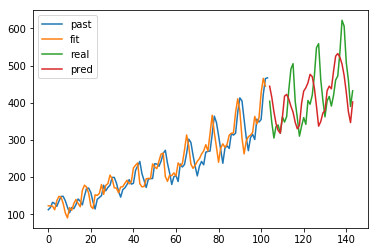

In [31]:
plt.plot(Xpast, label = 'past')
plt.plot(Xfit, label = 'fit')
plt.plot(Xreal, label = 'real')
plt.plot(pd.DataFrame(Xpred, index=Xreal.index), label = 'pred')
plt.legend(loc = 'upper left')

O modelo foi capaz de capturar tanto a sazonalidade quanto a tendência, embora o erro acumulado seja muito alto para o horizonte observado.

__Exercício__: qual o efeito de adicionar dropout às camadas mais prodfundas do modelo. Em particular, avalie o modelo considerando dropout de 20% nas últimas duas camadas (as duas que enxergam mais no passado).

Esta aula foi baseada no material de Krist Papadopoulos, disponível em https://github.com/kristpapadopoulos/seriesnet. Também foi usado material da DeepMind, os criadores da Wavenet, disponível no blog https://deepmind.com/blog/wavenet-generative-model-raw-audio/ e de Joseph Eddy, disponível em https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_conv/.